In [260]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import seaborn
from urllib import unquote_plus
from scipy.spatial.distance import pdist


from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from IPython.core.display import display
from collections import Counter

pd.options.display.max_colwidth = 300

In [261]:
# mapping for artist_idx values to artist names
artist_names = {}
with open('../GenreModeling/data/vocab_idx') as fin:
    for line in fin:
        line = line.strip().split()
        artist_names[int(line[1])] = line[0]

In [262]:
# 5750467_patches_patch_idx_shuffle.pkl  5750972_patches_patch_idx_shuffle.pkl  5759880_patches_patch_idx_shuffle.pkl
# 5750503_patches_patch_idx_shuffle.pkl  5759068_patches_patch_idx_shuffle.pkl  5759957_patches_patch_idx_shuffle.pkl
# 5750618_patches_patch_idx_shuffle.pkl  5759372_patches_patch_idx_shuffle.pkl  5759989_patches_patch_idx_shuffle.pkl
# 5750812_patches_patch_idx_shuffle.pkl  5759424_patches_patch_idx_shuffle.pkl
# 5750887_patches_patch_idx_shuffle.pkl  5759473_patches_patch_idx_shuffle.pkl

In [263]:
# load some example patch (from me!)
uid = 5759473
df = pd.read_pickle('../testData/patches/{}_patches_patch_idx_shuffle.pkl'.format(uid)).reset_index()

# we'll have to match this to some raw data so we can manually examine the aritsts in different patches
df_raw = pd.read_pickle('../testData/scrobbles_processed/{}.pkl'.format(uid))
df_raw['artist_name'] = df_raw['artist_idx'].apply(lambda x: artist_names.get(x))

# just add in the artist names here
df['artists'] = df_raw.groupby('patch_idx_shuffle').apply(lambda df: [artist_names.get(idx,'?') for idx in df['artist_idx']])



print "{} total patches".format(len(df))
#df.head()
# remove patches with NaNs in feature centroids
#df = df[]
#print "{} total patches with well-defined centroids".format(len(df))

2534 total patches


In [264]:
# Extract just pathces meeting the MPL criterion and with diveristy of 0.2 or less
mask = (df['centroid'].apply(lambda arr: ~np.any(np.isnan(arr))).values)&(df['n']>=5)&(df['diversity']<=0.2)
clust_data = df[mask].reset_index()
print "{} patches to be clustered".format(len(clust_data))


# Generate an array of the centroids of all these patches for clustering 
a = np.vstack(clust_data['centroid'])


1597 patches to be clustered


In [265]:
# "complete" linkage seems to make the most sense for us here. 
# From https://stats.stackexchange.com/questions/195446/choosing-the-right-linkage-method-for-hierarchical-clustering : 
"""Method of complete linkage or farthest neighbour. Proximity between two clusters is the proximity between their two most distant objects. 
This value is one of values of the input matrix. The metaphor of this built of cluster is circle (in the sense, by hobby or plot)."""

Z = linkage(a, 'complete')
c, coph_dists = cophenet(Z, pdist(a,metric='cosine'))
print c



0.551380196067


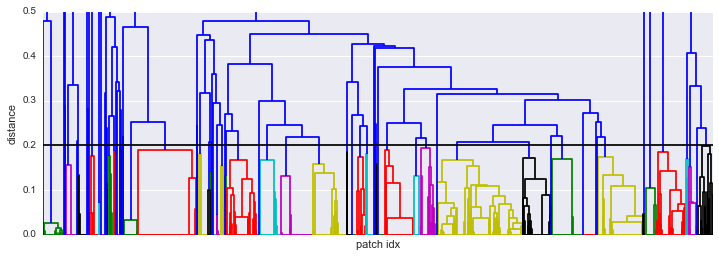

In [266]:
# Now draw the dendrogram
fig,ax =plt.subplots(1,1,figsize=(12, 4))
#ax.set_title('Hierarchical Clustering Dendrogram')
ax.set_xlabel('patch idx')
ax.set_ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=12.,  # font size for the x axis labels
    color_threshold=0.2,
    no_labels=True,

);
ax.set_ylim(0,0.5)
ax.axhline(0.2,c='k');


In [267]:
# Now generate the actual flat clustering using a distance threshold of 0.2

clusters = fcluster(Z,t=0.2,criterion='distance')
print "Total unique patch clusters identified: {}".format(max(clusters))

Total unique patch clusters identified: 71


In [268]:
assignments = np.repeat(np.nan,len(df))
assignments[np.where(mask)] = clusters
df['patch_clust'] = assignments


In [269]:
df.head()

,index,centroid,diversity,n,start_ts,artists,patch_clust
0,0,"[0.00513214113536, 0.00344395528751, 0.00163761303081, 0.0225100705871, 0.00416418206603, 0.000905654077649, 0.000141592757519, 0.000545171920937, 0.000116875105788, 0.000419249436156, 7.44106909024e-05, 0.016477962485, 0.0316548638154, 0.00153152026397, 0.111812235164, 0.00237215219217, 0.00589...",0.762156,283,2007-04-06 22:26:39,"[billy+talent, baddiel,+skinner+&+the+lightning+seeds, hot+chocolate, chumbawamba, ?, bellini, right+said+fred, ?, die+toten+hosen, ?, stefan+raab, dario+g, hape+kerkeling, soul+control, ?, ?, europe, blur, sasha, ricky+martin, gerry+&+the+pacemakers, queen, baddiel,+skinner+&+the+lightning+seed...",NaN
1,1,"[2.71961872049e-06, 0.0395114090666, 9.85369101627e-08, 0.0143138263031, 0.0902420730652, 9.85369101627e-08, 9.85369101627e-08, 0.00766002290747, 9.85369101627e-08, 3.52959212203e-05, 9.85369101627e-08, 4.72977168781e-07, 2.34517846187e-06, 9.85369101627e-08, 0.115077197658, 0.00141585715475, 9....",0.000000,17,2007-04-20 19:34:59,"[billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent, billy+talent]",41.0
2,2,"[2.86656535575e-08, 0.000747175993107, 0.000387381909045, 0.0562475103522, 0.0559293273308, 4.56701192478e-05, 0.001339425595, 0.00792889684148, 5.76523624348e-05, 1.4447489393e-06, 0.000206994684339, 0.00116339554963, 4.57790487313e-05, 0.00264363830116, 0.0114440512746, 0.000216907267339, 1.28...",0.000000,1,2007-04-22 19:20:11,[system+of+a+down],NaN
3,3,"[2.71961872049e-06, 0.0395114090666, 9.85369101627e-08, 0.0143138263031, 0.0902420730652, 9.85369101627e-08, 9.85369101627e-08, 0.00766002290747, 9.85369101627e-08, 3.52959212203e-05, 9.85369101627e-08, 4.72977168781e-07, 2.34517846187e-06, 9.85369101627e-08, 0.115077197658, 0.00141585715475, 9....",0.000000,5,2007-04-22 19:23:05,"[billy+talent, billy+talent, billy+talent, billy+talent, billy+talent]",41.0
4,4,"[2.86656535575e-08, 0.000747175993107, 0.000387381909045, 0.0562475103522, 0.0559293273308, 4.56701192478e-05, 0.001339425595, 0.00792889684148, 5.76523624348e-05, 1.4447489393e-06, 0.000206994684339, 0.00116339554963, 4.57790487313e-05, 0.00264363830116, 0.0114440512746, 0.000216907267339, 1.28...",0.000000,2,2007-04-23 09:08:51,"[system+of+a+down, system+of+a+down]",NaN


In [270]:
# Print out each of the clusters we've identified
for cluster in xrange(1,clusters.max()+1):
    current = clust_data.iloc[np.where(clusters==cluster)[0]][['diversity','artists','index','start_ts']]
    current['artists'] = current['artists'].apply(lambda x: ["{} ({})".format(unquote_plus(name.encode('ascii')),cnt)
        for name,cnt in sorted([(name,cnt) for name,cnt in Counter(x).iteritems()],key=lambda t: t[1],reverse=True)])
    display(current)
    


,diversity,artists,index,start_ts
924,0.000000,[hillsong (5)],1509,2009-03-08 12:19:17
929,0.000000,[hillsong (16)],1515,2009-03-17 16:06:26
946,0.000000,[hillsong (10)],1542,2009-04-07 17:36:25
954,0.000000,[hillsong (20)],1553,2009-04-19 11:39:20
967,0.000000,[hillsong (16)],1569,2009-05-03 20:35:21
968,0.000000,[hillsong (22)],1571,2009-05-04 15:54:43
969,0.000000,[hillsong (15)],1573,2009-05-06 15:43:30
975,0.000000,[hillsong (6)],1582,2009-05-10 13:11:07
977,0.000000,[hillsong (14)],1585,2009-05-11 12:33:30
978,0.000000,[hillsong (11)],1587,2009-05-11 20:49:50


,diversity,artists,index,start_ts
915,0.0,[deliverance (6)],1497,2009-02-17 21:25:37


,diversity,artists,index,start_ts
167,0.0,[bap (6)],287,2007-08-02 19:19:21
937,0.0,[bap (7)],1529,2009-03-28 15:31:16


,diversity,artists,index,start_ts
702,0.0,[sailor (6)],1180,2008-07-27 08:29:57
704,0.0,[sailor (9)],1182,2008-07-27 15:46:57


,diversity,artists,index,start_ts
886,0.0,[ennio morricone (7)],1451,2009-01-02 11:55:11
887,0.0,[ennio morricone (35)],1453,2009-01-03 14:31:36
888,0.0,[ennio morricone (34)],1455,2009-01-04 12:48:45
889,0.0,[ennio morricone (20)],1457,2009-01-05 20:31:14
890,0.0,[ennio morricone (13)],1459,2009-01-07 14:26:20
963,0.0,[ennio morricone (14)],1564,2009-04-30 13:04:17
1049,0.0,[nino rota (51)],1689,2009-07-03 15:36:48
1050,0.0,[nino rota (86)],1691,2009-07-20 10:40:03
1052,0.0,[nino rota (9)],1693,2009-07-20 15:48:25
1054,0.0,[nino rota (59)],1696,2009-07-21 17:59:08


,diversity,artists,index,start_ts
125,0.0,[e.s. posthumus (7)],211,2007-07-16 13:00:16
440,0.0,[e.s. posthumus (13)],767,2008-01-10 15:53:48


,diversity,artists,index,start_ts
196,0.000000,[hans zimmer (13)],339,2007-08-19 10:34:27
255,0.000000,[hans zimmer (8)],444,2007-09-21 15:52:58
285,0.000000,[hans zimmer (7)],497,2007-10-12 15:29:12
355,0.000000,[hans zimmer (15)],626,2007-11-22 15:59:25
392,0.000000,[hans zimmer (5)],685,2007-12-10 15:19:48
393,0.000000,[hans zimmer (14)],687,2007-12-10 15:34:02
398,0.000000,[hans zimmer (11)],697,2007-12-13 17:42:15
429,0.000000,[hans zimmer (7)],747,2008-01-01 17:28:09
448,0.000000,[hans zimmer (5)],781,2008-01-14 19:51:51
579,0.000000,[hans zimmer (11)],984,2008-04-23 20:51:23


,diversity,artists,index,start_ts
156,0.0,[celestial aeon project (9)],266,2007-07-25 23:11:17


,diversity,artists,index,start_ts
1550,0.0,[unheilig (24)],2463,2012-01-09 19:58:31
1555,0.0,[unheilig (11)],2470,2012-01-11 21:04:07
1558,0.0,[unheilig (6)],2475,2012-01-18 07:27:21


,diversity,artists,index,start_ts
1541,0.0,[wolfsheim (12)],2451,2011-12-13 18:37:32


,diversity,artists,index,start_ts
276,0.000000,[in extremo (5)],479,2007-10-02 09:51:35
278,0.000000,[in extremo (12)],483,2007-10-06 00:44:04
294,0.000000,[in extremo (5)],512,2007-10-20 00:39:30
307,0.000000,[in extremo (6)],537,2007-10-30 20:57:03
316,0.000000,[in extremo (12)],552,2007-11-01 07:48:33
319,0.000000,[in extremo (7)],558,2007-11-02 10:46:22
323,0.000000,[in extremo (7)],564,2007-11-03 15:21:27
348,0.000000,[schandmaul (5)],613,2007-11-16 20:10:29
364,0.000000,[schandmaul (5)],638,2007-11-25 20:35:02
368,0.020493,"[schandmaul (4), in extremo (1)]",643,2007-11-27 18:41:50


,diversity,artists,index,start_ts
327,0.0,[end of green (12)],571,2007-11-05 20:54:32


,diversity,artists,index,start_ts
838,0.098100,"[r.i.o. (1), basshunter (1), scooter (1), safri duo (1), yves larock (1)]",1375,2008-11-08 23:59:12
863,0.023712,"[guru josh project (2), yves larock (2), r.i.o. (1)]",1414,2008-12-12 09:42:17
1023,0.059834,"[r.i.o. (1), basshunter (1), atb (1), yves larock (1), guru josh project (1)]",1648,2009-06-11 13:22:40


,diversity,artists,index,start_ts
191,0.0,[sinch (11)],333,2007-08-17 19:45:19
199,0.0,[sinch (6)],342,2007-08-19 21:15:36
230,0.0,[sinch (5)],401,2007-09-07 13:10:43
264,0.0,[sinch (6)],460,2007-09-24 16:33:09
293,0.0,[sinch (5)],511,2007-10-20 00:23:02
367,0.0,[sinch (6)],642,2007-11-27 15:37:52
725,0.0,[sinch (11)],1210,2008-08-13 14:21:00
761,0.0,[sinch (26)],1264,2008-09-10 12:52:35
805,0.0,[sinch (15)],1321,2008-10-06 21:31:53
1174,0.0,[sinch (5)],1870,2009-11-16 15:45:39


,diversity,artists,index,start_ts
43,0.0,[eros ramazzotti (7)],77,2007-05-21 15:05:33
99,0.0,[eros ramazzotti (5)],169,2007-06-17 20:44:39


,diversity,artists,index,start_ts
26,0.04237,"[bryan adams (4), bryan adams, rod stewart & sting (1)]",45,2007-05-09 19:20:27
511,0.00000,[abba (7)],886,2008-03-11 20:20:00
555,0.00000,[phil collins (11)],952,2008-04-12 14:46:04
731,0.00000,[abba (6)],1219,2008-08-16 09:52:15
1059,0.00000,[abba (5)],1705,2009-07-26 07:26:06


,diversity,artists,index,start_ts
1077,0.102577,"[smokie (3), baccara (1), dschinghis khan (1)]",1735,2009-08-23 08:51:34


,diversity,artists,index,start_ts
1016,0.000000,[status quo (9)],1638,2009-06-09 08:49:25
1019,0.000000,[status quo (5)],1642,2009-06-09 16:58:46
1022,0.000000,[status quo (14)],1646,2009-06-10 14:28:48
1048,0.000000,[bachman-turner overdrive (17)],1687,2009-07-02 09:07:02
1121,0.000000,[slade (8)],1799,2009-10-04 18:30:24
1125,0.000000,"[status quo (4), ? (1)]",1803,2009-10-09 18:31:31
1126,0.000000,[status quo (8)],1804,2009-10-09 18:52:11
1142,0.000000,[slade (6)],1825,2009-10-24 17:13:06
1241,0.074337,"[status quo (6), rick derringer (1), the edgar winter group (1)]",1977,2010-03-09 20:43:47
1245,0.000000,[slade (8)],1983,2010-03-24 18:15:49


,diversity,artists,index,start_ts
6,0.0,[deep purple (7)],13,2007-04-29 09:38:10
50,0.0,[deep purple (5)],90,2007-05-23 19:26:50
1010,0.0,[grand funk railroad (15)],1632,2009-06-04 20:22:24
1226,0.0,[deep purple (6)],1951,2010-02-05 20:08:21
1406,0.0,[grand funk railroad (7)],2237,2010-12-13 20:47:00


,diversity,artists,index,start_ts
981,0.0,[stevie wonder (24)],1592,2009-05-14 08:55:04
1087,0.0,[stevie wonder (7)],1749,2009-08-29 16:44:42
1289,0.0,[stevie wonder (8)],2061,2010-06-25 19:04:44


,diversity,artists,index,start_ts
973,0.000000e+00,[the hollies (11)],1579,2009-05-09 15:17:25
993,1.110223e-16,"[? (7), the hollies (2)]",1609,2009-05-24 17:37:11
1035,0.000000e+00,[the hollies (5)],1666,2009-06-22 16:47:33
1213,0.000000e+00,[the hollies (5)],1927,2009-12-18 21:22:37
1214,0.000000e+00,[the hollies (6)],1929,2009-12-19 11:16:34
1281,0.000000e+00,[the hollies (5)],2047,2010-06-13 08:08:57


,diversity,artists,index,start_ts
1295,0.0,[gordon lightfoot (7)],2070,2010-07-05 15:20:51
1395,0.0,[gordon lightfoot (15)],2222,2010-10-24 08:17:43


,diversity,artists,index,start_ts
57,0.0,[electric light orchestra (7)],100,2007-05-27 16:36:29
144,0.0,[fleetwood mac (6)],245,2007-07-22 19:54:40
259,0.0,[bryan ferry (11)],451,2007-09-22 16:30:49
922,0.0,[electric light orchestra (18)],1506,2009-03-06 08:17:06
982,0.0,[toto (27)],1593,2009-05-14 10:26:26
1394,0.0,[electric light orchestra (9)],2221,2010-10-23 14:52:05


,diversity,artists,index,start_ts
735,0.0,[dick dale and his del-tones (5)],1226,2008-08-20 13:39:06


,diversity,artists,index,start_ts
849,0.0,[atomic fireballs (5)],1394,2008-11-24 16:56:35


,diversity,artists,index,start_ts
1297,0.000000,[talco (18)],2074,2010-07-07 05:20:12
1298,0.000000,[talco (6)],2076,2010-07-07 15:19:49
1304,0.000000,[talco (7)],2088,2010-07-15 11:48:58
1305,0.040798,"[talco (45), the locos (6)]",2090,2010-07-15 20:16:16
1306,0.000000,[talco (9)],2092,2010-07-17 08:22:25
1307,0.000000,[talco (23)],2094,2010-07-18 09:45:51
1309,0.000000,[talco (23)],2098,2010-07-20 09:14:30
1317,0.000000,[talco (15)],2110,2010-07-25 11:51:58
1319,0.000000,[talco (24)],2114,2010-07-27 11:35:56
1320,0.000000,[talco (33)],2116,2010-07-27 22:36:51


,diversity,artists,index,start_ts
280,0.000000,[ska-p (7)],487,2007-10-06 22:11:14
281,0.000000,[ska-p (13)],489,2007-10-08 13:43:15
282,0.000000,[ska-p (15)],491,2007-10-09 12:58:52
310,0.000000,[ska-p (8)],541,2007-10-31 14:34:11
350,0.000000,[ska-p (5)],617,2007-11-18 16:43:04
362,0.000000,[ska-p (6)],635,2007-11-25 13:54:04
434,0.000000,[ska-p (5)],757,2008-01-04 16:40:55
502,0.000000,[ska-p (24)],873,2008-02-22 19:58:44
503,0.000000,[ska-p (24)],875,2008-02-26 15:08:14
504,0.000000,[ska-p (82)],877,2008-03-01 00:29:44


,diversity,artists,index,start_ts
123,0.0,[porcupine tree (6)],209,2007-07-16 01:19:34
318,0.0,[porcupine tree (7)],556,2007-11-01 11:26:19


,diversity,artists,index,start_ts
951,0.0,[jethro tull (8)],1549,2009-04-12 13:53:02
952,0.0,[jethro tull (19)],1551,2009-04-16 16:19:30


,diversity,artists,index,start_ts
124,0.0,[opeth (5)],210,2007-07-16 01:50:57
243,0.0,[opeth (9)],423,2007-09-12 08:02:00
250,0.0,[opeth (8)],436,2007-09-18 14:12:28
271,0.0,[katatonia (5)],472,2007-09-30 23:35:05
273,0.0,[katatonia (10)],475,2007-10-01 01:12:16
291,0.0,[katatonia (11)],509,2007-10-19 23:22:56
302,0.0,[katatonia (5)],527,2007-10-26 22:26:09
306,0.0,[katatonia (13)],535,2007-10-30 20:04:18
315,0.0,[katatonia (7)],550,2007-10-31 22:55:56
317,0.0,[katatonia (6)],554,2007-11-01 10:53:46


,diversity,artists,index,start_ts
122,0.0,[in flames (9)],207,2007-07-15 22:41:01
236,0.0,[in flames (14)],412,2007-09-10 14:14:42
296,0.0,[in flames (8)],515,2007-10-22 10:00:49
329,0.0,[in flames (5)],575,2007-11-06 22:33:16
469,0.0,[soilwork (6)],818,2008-01-24 15:10:38
656,0.0,[soilwork (18)],1104,2008-06-02 14:43:50
713,0.0,[in flames (6)],1193,2008-07-31 17:45:29


,diversity,artists,index,start_ts
142,0.0,[amorphis (5)],241,2007-07-22 13:13:26
475,0.0,[dark tranquillity (6)],828,2008-01-31 13:31:59


,diversity,artists,index,start_ts
287,0.0,[fozzy (8)],501,2007-10-17 14:23:00
470,0.0,[fozzy (16)],820,2008-01-25 23:03:48
1344,0.0,[fozzy (11)],2150,2010-09-02 20:57:07


,diversity,artists,index,start_ts
297,0.0,[sonata arctica (10)],517,2007-10-22 10:28:58
298,0.0,[sonata arctica (5)],519,2007-10-23 13:33:18
300,0.0,[sonata arctica (7)],523,2007-10-25 13:12:47
301,0.0,[sonata arctica (8)],525,2007-10-25 21:11:59
303,0.0,[sonata arctica (12)],529,2007-10-27 22:27:59
320,0.0,[sonata arctica (6)],559,2007-11-02 11:15:17
336,0.0,[sonata arctica (8)],589,2007-11-10 23:52:37
464,0.0,[sonata arctica (12)],811,2008-01-22 15:20:27
1350,0.0,[sonata arctica (16)],2158,2010-09-06 12:40:50


,diversity,artists,index,start_ts
358,0.000000,[judas priest (12)],630,2007-11-23 22:33:51
363,0.000000,[judas priest (5)],637,2007-11-25 20:16:00
366,0.012390,"[judas priest (13), iron maiden (1)]",640,2007-11-26 14:12:01
382,0.000000,[judas priest (8)],668,2007-12-03 21:06:37
387,0.000000,[judas priest (11)],677,2007-12-07 23:29:08
394,0.000000,[judas priest (7)],689,2007-12-10 20:22:49
492,0.046256,"[judas priest (4), iron maiden (2)]",856,2008-02-08 23:05:27
493,0.000000,[judas priest (16)],858,2008-02-11 08:48:49
562,0.000000,[judas priest (9)],962,2008-04-15 18:57:01
1351,0.000000,[judas priest (9)],2160,2010-09-07 11:08:54


,diversity,artists,index,start_ts
290,0.000000,[metallica (5)],507,2007-10-19 14:26:35
312,0.000000,[metallica (5)],545,2007-10-31 19:01:16
607,0.000000,[iron maiden (11)],1031,2008-05-10 08:06:31
762,0.117044,"[iron maiden (4), metallica (3)]",1265,2008-09-10 14:35:24
767,0.000000,"[? (3), metallica (2)]",1272,2008-09-15 19:12:10
1111,0.000000,[metallica (6)],1784,2009-09-22 15:54:28
1182,0.000000,[iron maiden (5)],1880,2009-11-17 15:10:20
1237,0.000000,[metallica (8)],1969,2010-02-24 18:16:42
1347,0.000000,[iron maiden (6)],2154,2010-09-04 19:11:34


,diversity,artists,index,start_ts
1516,0.0,[3oh!3 (6)],2409,2011-10-10 07:43:54
1520,0.0,[3oh!3 (8)],2417,2011-10-25 13:29:47


,diversity,artists,index,start_ts
460,0.0,[american hi-fi (12)],803,2008-01-20 13:56:54
950,0.0,[plain white t's (7)],1548,2009-04-11 09:57:07


,diversity,artists,index,start_ts
19,0.000000,[sum 41 (5)],33,2007-05-08 16:36:12
52,0.000000,[sum 41 (16)],93,2007-05-25 19:28:01
72,0.071697,"[sum 41 (4), hoobastank (1)]",124,2007-06-02 20:13:51
83,0.000000,[good charlotte (15)],139,2007-06-06 13:28:41
103,0.042224,"[good charlotte (5), my chemical romance (2)]",176,2007-06-20 07:17:42
119,0.033282,"[good charlotte (19), fall out boy (3)]",202,2007-07-14 00:36:09
126,0.000000,[good charlotte (16)],212,2007-07-16 13:50:07
129,0.000000,[good charlotte (10)],217,2007-07-17 01:37:40
131,0.000000,[good charlotte (37)],219,2007-07-17 15:37:07
132,0.000000,[good charlotte (9)],221,2007-07-17 23:11:05


,diversity,artists,index,start_ts
55,0.000000,[papa roach (13)],96,2007-05-25 22:47:50
104,0.000000,[papa roach (13)],177,2007-06-20 09:23:28
106,0.000000,[papa roach (13)],181,2007-07-11 20:22:56
136,0.050189,"[papa roach (5), alter bridge (1)]",229,2007-07-19 10:42:44
148,0.000000,[papa roach (14)],252,2007-07-23 10:23:54
158,0.000000,[alter bridge (5)],270,2007-07-26 19:06:21
159,0.000000,[alter bridge (5)],272,2007-07-26 21:12:14
185,0.000000,[alter bridge (20)],323,2007-08-14 15:46:39
193,0.000000,[alter bridge (5)],336,2007-08-17 22:18:30
195,0.000000,[alter bridge (11)],338,2007-08-19 09:40:32


,diversity,artists,index,start_ts
0,0.000000,[billy talent (17)],1,2007-04-20 19:34:59
1,0.000000,[billy talent (5)],3,2007-04-22 19:23:05
2,0.000000,[billy talent (16)],5,2007-04-23 09:14:01
3,0.000000,[billy talent (6)],7,2007-04-23 14:25:04
4,0.000000,[billy talent (8)],9,2007-04-24 15:05:08
22,0.000000,[billy talent (12)],38,2007-05-08 21:15:59
27,0.000000,[billy talent (13)],47,2007-05-09 21:15:23
34,0.000000,[billy talent (24)],59,2007-05-15 11:54:32
39,0.000000,[billy talent (6)],69,2007-05-19 18:44:10
54,0.000000,[billy talent (22)],95,2007-05-25 21:19:19


,diversity,artists,index,start_ts
65,0.000000,[linkin park (12)],113,2007-05-30 13:42:39
80,0.049151,"[linkin park (4), papa roach (1)]",135,2007-06-05 15:12:47
86,0.000000,[linkin park (6)],143,2007-06-07 11:17:17
97,0.000000,[linkin park (12)],165,2007-06-17 13:18:14
107,0.000000,[linkin park (6)],183,2007-07-11 21:26:37
137,0.000000,[linkin park (5)],231,2007-07-19 14:26:49
162,0.000000,[linkin park (9)],278,2007-07-27 20:51:09
184,0.000000,[linkin park (5)],321,2007-08-13 20:02:24
189,0.000000,[linkin park (10)],329,2007-08-16 14:22:40
205,0.000000,[linkin park (6)],354,2007-08-27 13:46:09


,diversity,artists,index,start_ts
995,1.110223e-16,"[? (17), manchester united (4)]",1611,2009-05-27 10:55:41


,diversity,artists,index,start_ts
360,0.0,[at the drive-in (6)],632,2007-11-24 00:03:17
384,0.0,[at the drive-in (8)],671,2007-12-05 15:32:31
385,0.0,[at the drive-in (20)],673,2007-12-05 20:22:27
386,0.0,[at the drive-in (12)],675,2007-12-07 16:21:12
457,0.0,[at the drive-in (6)],798,2008-01-20 11:55:48
458,0.0,[at the drive-in (7)],800,2008-01-20 13:01:49
459,0.0,[at the drive-in (6)],802,2008-01-20 13:35:42
523,0.0,[at the drive-in (10)],904,2008-03-20 13:30:09
532,0.0,[at the drive-in (10)],916,2008-03-30 15:10:12
1065,0.0,[minus the bear (6)],1715,2009-08-04 10:21:50


,diversity,artists,index,start_ts
160,0.0,[two gallants (6)],274,2007-07-26 21:51:53
305,0.0,[two gallants (13)],533,2007-10-29 13:42:54
400,0.0,[two gallants (9)],701,2007-12-17 11:46:14
465,0.0,[two gallants (9)],812,2008-01-22 16:14:35
471,0.0,[two gallants (6)],821,2008-01-26 00:15:54
473,0.0,[two gallants (36)],825,2008-01-27 22:16:38
581,0.0,[two gallants (8)],986,2008-04-24 11:15:45
717,0.0,[two gallants (9)],1199,2008-08-09 20:17:00
718,0.0,[two gallants (17)],1201,2008-08-10 11:10:45
801,0.0,[two gallants (15)],1315,2008-10-05 19:29:43


,diversity,artists,index,start_ts
42,0.000000,[death cab for cutie (5)],75,2007-05-20 20:01:52
183,0.000000,[death cab for cutie (6)],319,2007-08-13 15:40:01
192,0.000000,[sufjan stevens (6)],334,2007-08-17 20:29:43
270,0.000000,[death cab for cutie (7)],470,2007-09-29 23:57:19
407,0.000000,[the decemberists (14)],711,2007-12-19 14:44:35
408,0.000000,[the decemberists (5)],713,2007-12-19 18:30:02
432,0.000000,[the decemberists (8)],753,2008-01-02 21:38:02
438,0.085279,"[the decemberists (7), death cab for cutie (3)]",764,2008-01-09 16:03:14
442,0.000000,[the decemberists (5)],771,2008-01-10 21:47:34
451,0.000000,[the decemberists (9)],786,2008-01-15 15:20:38


,diversity,artists,index,start_ts
9,0.0,[belle and sebastian (12)],17,2007-05-01 20:36:27
10,0.0,[belle and sebastian (9)],19,2007-05-02 19:15:02
11,0.0,[belle and sebastian (12)],21,2007-05-04 13:08:41
15,0.0,[belle and sebastian (6)],28,2007-05-07 13:31:01
30,0.0,[belle and sebastian (7)],53,2007-05-12 00:10:18
47,0.0,[belle and sebastian (12)],84,2007-05-22 20:29:11
59,0.0,[belle and sebastian (13)],103,2007-05-27 22:20:54
88,0.0,[belle and sebastian (10)],147,2007-06-12 07:12:09
110,0.0,[belle and sebastian (12)],189,2007-07-11 23:51:54
217,0.0,[belle and sebastian (13)],376,2007-08-31 15:08:41


,diversity,artists,index,start_ts
489,0.0,[the tellers (6)],851,2008-02-08 14:14:53
580,0.0,[the tellers (11)],985,2008-04-24 10:45:51
1176,0.0,[the tellers (6)],1872,2009-11-16 16:36:15


,diversity,artists,index,start_ts
7,0.0,[james blunt (10)],14,2007-04-30 18:03:51
883,0.0,[michael jackson (5)],1446,2008-12-31 18:00:39


,diversity,artists,index,start_ts
128,0.127316,"[avril lavigne (2), maroon 5 (2), jennifer lopez (1)]",216,2007-07-17 00:14:03
130,0.000000,[avril lavigne (6)],218,2007-07-17 12:31:34
467,0.000000,[maroon 5 (7)],816,2008-01-24 13:41:16
1565,0.000000,[bruno mars (6)],2484,2012-01-24 16:44:30


,diversity,artists,index,start_ts
1324,0.0,[madonna (18)],2123,2010-08-03 18:51:08


,diversity,artists,index,start_ts
414,0.0,[bob marley (14)],722,2007-12-22 17:47:15
426,0.0,[bob marley (5)],742,2007-12-31 00:56:32
608,0.0,[bob marley (6)],1033,2008-05-10 09:23:14
645,0.0,[bob marley (14)],1090,2008-05-30 15:46:06
940,0.0,[bob marley (11)],1533,2009-03-30 14:41:10
1269,0.0,[bob marley (14)],2024,2010-05-13 10:30:42
1300,0.0,[bob marley (5)],2080,2010-07-08 20:37:32
1311,0.0,[bob marley (10)],2101,2010-07-21 08:59:38
1349,0.0,[bob marley (13)],2157,2010-09-06 10:02:06
1362,0.0,[bob marley (18)],2176,2010-09-20 12:48:12


,diversity,artists,index,start_ts
5,0.000000,[bob dylan (9)],11,2007-04-27 22:07:27
8,0.000000,[bob dylan (6)],16,2007-04-30 20:25:25
14,0.000000,[bob dylan (9)],27,2007-05-06 14:36:12
37,0.000000,[bob dylan (5)],65,2007-05-17 09:05:47
61,0.000000,[bob dylan (5)],107,2007-05-28 15:56:44
76,0.000000,[bob dylan (13)],130,2007-06-04 11:39:34
141,0.000000,[bob dylan (12)],239,2007-07-22 09:17:34
143,0.000000,[bob dylan (5)],243,2007-07-22 14:45:32
166,0.000000,[bob dylan (7)],286,2007-08-01 18:29:22
180,0.000000,[bob dylan (7)],313,2007-08-11 10:21:19


,diversity,artists,index,start_ts
892,0.0,[johnny cash (47)],1461,2009-01-08 14:01:41
895,0.0,[johnny cash (73)],1465,2009-01-11 13:29:42
898,0.0,[johnny cash (47)],1470,2009-01-15 11:04:48
909,0.0,[elvis presley (5)],1488,2009-02-05 20:42:45
923,0.0,[elvis presley (7)],1507,2009-03-06 19:34:13
983,0.0,[johnny cash (6)],1595,2009-05-15 17:18:15
1027,0.0,[elvis presley (8)],1655,2009-06-15 17:44:06
1067,0.0,[elvis presley (7)],1719,2009-08-09 20:01:36
1076,0.0,[elvis presley (19)],1733,2009-08-21 15:08:55
1080,0.0,[elvis presley (6)],1740,2009-08-25 19:44:08


,diversity,artists,index,start_ts
13,0.040199,"[eric clapton (5), queen (1)]",25,2007-05-05 14:35:27
356,0.000000,[jimi hendrix (7)],627,2007-11-22 17:10:47
428,0.000000,[the who (8)],745,2007-12-31 08:38:32
449,0.000000,[jimi hendrix (5)],783,2008-01-14 20:41:39
456,0.000000,[paul mccartney (6)],796,2008-01-19 20:30:56
516,0.000000,[the who (6)],892,2008-03-16 18:20:47
591,0.000000,[the beatles (9)],1003,2008-04-30 19:09:27
592,0.000000,[creedence clearwater revival (14)],1005,2008-05-01 13:11:20
800,0.000000,[creedence clearwater revival (14)],1314,2008-10-04 18:23:31
846,0.000000,[the who (5)],1389,2008-11-16 18:51:30


,diversity,artists,index,start_ts
16,0.000000,[the killers (6)],29,2007-05-07 13:57:50
20,0.000000,[radiohead (5)],34,2007-05-08 17:10:13
21,0.079902,"[franz ferdinand (2), muse (2), arctic monkeys (1)]",36,2007-05-08 17:37:54
23,0.000000,[the killers (7)],40,2007-05-09 12:37:33
24,0.000000,[arctic monkeys (5)],42,2007-05-09 13:34:30
31,0.000000,[arctic monkeys (7)],55,2007-05-14 18:55:43
36,0.067514,"[the smashing pumpkins (4), coldplay (1)]",63,2007-05-16 17:34:24
38,0.000000,[the killers (7)],67,2007-05-18 23:38:52
40,0.000000,[arctic monkeys (8)],71,2007-05-19 22:49:12
41,0.000000,[arctic monkeys (9)],73,2007-05-20 10:06:22


,diversity,artists,index,start_ts
71,0.111347,"[red hot chili peppers (5), the killers (3), green day (2)]",122,2007-06-01 22:16:32
85,0.032346,"[red hot chili peppers (7), green day (1)]",141,2007-06-06 14:59:18
90,0.000000,[green day (5)],151,2007-06-12 20:03:45
91,0.066892,"[red hot chili peppers (6), the smashing pumpkins (4)]",153,2007-06-12 20:37:44
95,0.073934,"[red hot chili peppers (4), green day (4)]",161,2007-06-16 00:16:13
157,0.012836,"[red hot chili peppers (4), foo fighters (1)]",268,2007-07-26 18:16:45
171,0.164457,"[red hot chili peppers (2), u2 (2), green day (1)]",295,2007-08-05 12:49:35
190,0.000000,[green day (7)],331,2007-08-17 15:38:02
194,0.000000,[green day (5)],337,2007-08-18 14:06:54
207,0.000000,[green day (6)],358,2007-08-27 16:06:02


,diversity,artists,index,start_ts
32,0.000000,[jack johnson (5)],57,2007-05-15 09:11:33
231,0.000000,[rooney (6)],403,2007-09-07 21:50:04
239,0.000000,[rooney (12)],416,2007-09-10 17:04:42
252,0.000000,[rooney (22)],439,2007-09-18 15:20:50
254,0.000000,[rooney (9)],443,2007-09-21 15:20:12
269,0.000000,[rooney (8)],469,2007-09-29 23:29:54
277,0.000000,[jack johnson (10)],481,2007-10-02 23:37:11
359,0.000000,[rooney (10)],631,2007-11-23 23:27:01
381,0.000000,[rooney (10)],667,2007-12-03 20:28:11
401,0.000000,[rooney (11)],702,2007-12-17 18:33:59


,diversity,artists,index,start_ts
960,1.110223e-16,"[? (13), caesars (2)]",1560,2009-04-23 21:30:03


,diversity,artists,index,start_ts
997,0.0,[flogging molly (13)],1613,2009-05-28 09:09:45
1000,0.0,[flogging molly (16)],1616,2009-05-29 15:37:45
1002,0.0,[flogging molly (16)],1619,2009-05-30 14:32:37
1003,0.0,[flogging molly (10)],1621,2009-05-31 10:33:08
1005,0.0,[flogging molly (7)],1624,2009-06-01 14:39:19
1006,0.0,[flogging molly (11)],1626,2009-06-02 17:12:13
1008,0.0,[flogging molly (59)],1629,2009-06-03 12:13:55
1011,0.0,[flogging molly (56)],1633,2009-06-04 21:35:11
1015,0.0,[flogging molly (40)],1637,2009-06-08 19:48:53
1018,0.0,[flogging molly (13)],1641,2009-06-09 15:14:36


,diversity,artists,index,start_ts
146,0.0,[daft punk (9)],248,2007-07-22 22:02:27
186,0.0,[daft punk (6)],325,2007-08-15 20:49:14
629,0.0,[daft punk (7)],1065,2008-05-21 23:39:22


,diversity,artists,index,start_ts
1066,0.0,[nine inch nails (5)],1717,2009-08-05 09:05:38
1446,0.0,[nine inch nails (6)],2301,2011-04-06 17:12:39


,diversity,artists,index,start_ts
17,0.000000,[system of a down (5)],30,2007-05-07 14:28:40
18,0.000000,[the offspring (12)],32,2007-05-08 15:49:44
25,0.000000,[the offspring (7)],43,2007-05-09 14:00:47
28,0.000000,[system of a down (12)],49,2007-05-11 17:50:26
29,0.000000,[system of a down (31)],51,2007-05-11 22:18:14
33,0.017193,"[system of a down (24), the offspring (3)]",58,2007-05-15 09:26:43
35,0.000000,[the offspring (10)],61,2007-05-15 21:01:18
44,0.000000,[the offspring (7)],78,2007-05-21 15:40:13
46,0.000000,[the offspring (13)],82,2007-05-22 18:20:01
51,0.000000,[the offspring (23)],92,2007-05-24 20:28:20


,diversity,artists,index,start_ts
1064,0.0,[mogwai (5)],1714,2009-08-04 10:01:58


,diversity,artists,index,start_ts
266,0.000000,[maeckes und plan b (13)],464,2007-09-26 22:32:09
267,0.021729,"[maeckes und plan b (4), prinz pi (1)]",466,2007-09-27 23:18:22
274,0.000000,[maeckes und plan b (7)],476,2007-10-01 01:53:07
284,0.000000,[maeckes und plan b (8)],495,2007-10-11 14:20:43


,diversity,artists,index,start_ts
1274,0.000000,[the skatoons (13)],2033,2010-05-27 13:35:10
1275,0.000000,[the skatoons (9)],2035,2010-06-07 15:53:54
1276,0.000000,[the skatoons (76)],2037,2010-06-09 09:45:51
1277,0.000000,[the skatoons (27)],2039,2010-06-09 14:26:25
1283,0.000000,[the skatoons (22)],2051,2010-06-15 09:17:29
1294,0.000000,[the skatoons (33)],2068,2010-07-04 11:20:26
1310,0.000000,[sondaschule (19)],2099,2010-07-20 10:09:59
1313,0.002949,"[the skatoons (19), sondaschule (11)]",2104,2010-07-22 11:47:57
1321,0.000000,[the skatoons (11)],2117,2010-07-28 10:30:00
1323,0.000000,[the skatoons (18)],2121,2010-07-31 06:55:51


,diversity,artists,index,start_ts
170,0.000000,[madsen (11)],293,2007-08-05 11:57:51
173,0.000000,[madsen (15)],299,2007-08-07 15:59:36
174,0.024784,"[madsen (19), k.i.z. (3)]",301,2007-08-08 19:49:59
176,0.009268,"[madsen (5), die doofen (2)]",305,2007-08-09 15:46:45
178,0.000000,[madsen (12)],309,2007-08-10 21:55:41
188,0.000000,[madsen (11)],327,2007-08-16 13:29:39
214,0.000000,[madsen (5)],370,2007-08-31 07:06:41
227,0.000000,[madsen (5)],395,2007-09-04 17:54:14
232,0.000000,[madsen (12)],405,2007-09-08 06:08:41
233,0.004036,"[madsen (7), die fantastischen vier (1), die firma (1), die Ärzte (1)]",407,2007-09-08 15:51:56


,diversity,artists,index,start_ts
12,0.000000,[die prinzen (6)],23,2007-05-05 07:47:29
423,0.000000,[xavier naidoo (6)],738,2007-12-28 18:44:19
864,0.072616,"[ich und ich (3), polarkreis 18 (2), peter fox (1)]",1415,2008-12-12 09:58:50
865,0.071056,"[polarkreis 18 (4), ich und ich (3), die Ärzte (1)]",1417,2008-12-12 13:30:46
936,0.000000,[xavier naidoo (5)],1527,2009-03-26 21:53:21
1375,0.000000,[ich und ich (15)],2193,2010-09-30 13:44:55


,diversity,artists,index,start_ts
115,0.030408,"[k.i.z. (5), deichkind (1)]",195,2007-07-13 00:47:48
279,0.005138,"[k.i.z. (20), prinz pi (1)]",485,2007-10-06 20:34:56
309,0.036353,"[k.i.z. (4), die firma (1)]",540,2007-10-31 14:00:33
331,0.000000,[k.i.z. (8)],579,2007-11-07 15:05:39
427,0.000000,[k.i.z. (8)],744,2007-12-31 01:28:38
589,0.000000,[k.i.z. (8)],999,2008-04-29 21:30:06
634,0.055651,"[k.i.z. (4), deichkind (2), die fantastischen vier (1)]",1073,2008-05-26 09:31:34
636,0.000000,[k.i.z. (5)],1076,2008-05-27 07:46:28
686,0.000000,[k.i.z. (6)],1153,2008-07-19 20:14:07
687,0.000000,[k.i.z. (6)],1155,2008-07-19 20:48:28


,diversity,artists,index,start_ts
1535,0.0,"[? (6), seeed (3)]",2441,2011-11-21 06:28:13
1537,0.0,[seeed (5)],2443,2011-12-02 15:01:52


,diversity,artists,index,start_ts
120,0.000000,[beatsteaks (12)],204,2007-07-15 21:25:13
121,0.000000,[beatsteaks (10)],206,2007-07-15 22:15:08
165,0.000000,[die doofen (9)],284,2007-07-28 08:52:57
172,0.007486,"[die doofen (10), madsen (3)]",297,2007-08-06 20:37:14
198,0.000000,[die doofen (16)],341,2007-08-19 20:04:19
203,0.000000,[die doofen (5)],350,2007-08-25 19:48:24
247,0.000000,[die doofen (16)],431,2007-09-13 15:27:16
357,0.000000,[wir sind helden (10)],629,2007-11-23 21:54:09
370,0.000000,[wir sind helden (6)],646,2007-11-28 11:46:45
371,0.000000,[wir sind helden (6)],648,2007-11-29 15:51:15
